## Combining txt files into one csv file per session

In [1]:
import os
import pandas as pd

def detect_delimiter(file_path):
    with open(file_path, 'r') as file:
        first_line = file.readline()
        if ',' in first_line:
            return ','
        elif '\t' in first_line:
            return '\t'
        elif ' ' in first_line:
            return ' '
        else:
            raise ValueError("Unknown delimiter")

directory = r'C:/Users/kirahoos/Library/Mobile Documents/com~apple~CloudDocs/Documents/Master Thesis/4 Data/Session 1'   # Do this for each session (1, 2, 3)

data_frames = []

for filename in os.listdir(directory):
    if filename.endswith(".txt") or filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        delimiter = detect_delimiter(file_path)
        df = pd.read_csv(file_path, delimiter=delimiter)
        data_frames.append(df)

combined_df = pd.concat(data_frames, ignore_index=True)

combined_df.to_csv(r'C:/Users/kirahoos/Library/Mobile Documents/com~apple~CloudDocs/Documents/Master Thesis/4 Data/data_session2.csv', index=False)  # Change name for each session (1, 2, 3)

# Combined files manually in excel

## Importing libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
import warnings 
warnings.simplefilter(action='ignore', category=RuntimeWarning)

## Load DataFrame

In [3]:
original_df = pd.read_csv('Data_Preprocessed.csv', sep=";")

In [4]:
df = original_df.copy()

## Checking for missing values (NaN-values)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19440 entries, 0 to 19439
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   session      19440 non-null  int64 
 1   participant  19440 non-null  int64 
 2   stim         19440 non-null  object
 3   trial        19440 non-null  int64 
 4   number       19440 non-null  int64 
 5   target       19440 non-null  bool  
 6   press        19440 non-null  bool  
 7   corr         19440 non-null  int64 
 8   rt           19440 non-null  object
 9   t_task       19440 non-null  object
 10  t_num        19440 non-null  object
 11  t_fix        19440 non-null  object
 12  t_resp       19440 non-null  object
 13  age          19440 non-null  int64 
dtypes: bool(2), int64(6), object(6)
memory usage: 1.8+ MB


## Defining dprime

In [6]:
# Function dprime
def calculate_dprime(hit_rate, fa_rate):
    z_hit_rate = norm.ppf(hit_rate)
    z_fa_rate = norm.ppf(fa_rate)
    d_prime = z_hit_rate - z_fa_rate
    return d_prime

In [7]:
df['rt'] = df['rt'].astype(str).str.replace(',', '.')

df['rt'] = df['rt'].astype(float)    

results = []
excluded_trials = 0

for participant in df['participant'].unique():
   
    age = df[df['participant'] == participant]['age'].iloc[0]
    
    for session in df['session'].unique():
        subset = df[(df['participant'] == participant) & (df['session'] == session)]

        # Outlier reaction time
        non_zero_rts = subset['rt'][subset['rt'] > 0]
        
        if not non_zero_rts.empty:
            Q1 = np.percentile(non_zero_rts, 25)
            Q3 = np.percentile(non_zero_rts, 75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outlier_mask = (subset['rt'] < lower_bound) | (subset['rt'] > upper_bound)
            num_excluded = outlier_mask.sum()
            excluded_trials += num_excluded
            
            valid_subset = subset[~outlier_mask]

        # dprime values + correction
        for stim in df['stim'].unique():
            # Filter für aktuellen Stimulus
            stim_subset = subset[subset['stim'] == stim]
            
            hits = np.sum((stim_subset['target'] == True) & (stim_subset['press'] == True))
            misses = np.sum((stim_subset['target'] == True) & (stim_subset['press'] == False))
            false_alarms = np.sum((stim_subset['target'] == False) & (stim_subset['press'] == True))
            correct_rejections = np.sum((stim_subset['target'] == False) & (stim_subset['press'] == False))
            
            # log-linear correction
            signal_trials = hits + misses
            noise_trials = false_alarms + correct_rejections
            hit_rate_loglinear = (hits + 0.5) / (signal_trials + 1) if signal_trials > 0 else 0
            fa_rate_loglinear = (false_alarms + 0.5) / (noise_trials + 1) if noise_trials > 0 else 0
            
            d_prime = calculate_dprime(hit_rate_loglinear, fa_rate_loglinear)

             # median reaction time
            hit_trials = stim_subset[(stim_subset['target'] == True) & (stim_subset['press'] == True)]
            non_zero_hit_rts = hit_trials['rt'][hit_trials['rt'] > 0]
            median_rt = non_zero_hit_rts.median() if not non_zero_hit_rts.empty else np.nan
            
            results.append({
                'participant': participant,
                'session': session,
                'stim': stim,
                'age': age,
                'd_prime': round(d_prime, 4),  
                'median_rt': round(median_rt, 4)  
            })

results_df = pd.DataFrame(results)

In [8]:
print(results_df)

     participant  session   stim  age  d_prime  median_rt
0              1        1  theta   28   2.1196     1.0917
1              1        1  gamma   28      NaN        NaN
2              1        1   sham   28      NaN        NaN
3              1        2  theta   28      NaN        NaN
4              1        2  gamma   28   2.0844     0.9730
..           ...      ...    ...  ...      ...        ...
319           36        2  gamma   20      NaN        NaN
320           36        2   sham   20   1.6241     0.7013
321           36        3  theta   20   1.5587     0.6554
322           36        3  gamma   20      NaN        NaN
323           36        3   sham   20      NaN        NaN

[324 rows x 6 columns]


In [9]:
# Only keep rows where d_prime is not 0 and is not NaN
results_df_cleaned = results_df[(results_df['d_prime'] != 0) & (~results_df['d_prime'].isna())]

In [10]:
print(results_df_cleaned)

     participant  session   stim  age  d_prime  median_rt
0              1        1  theta   28   2.1196     1.0917
4              1        2  gamma   28   2.0844     0.9730
8              1        3   sham   28   2.2215     0.9115
9              2        1  theta   25   2.2215     0.8953
13             2        2  gamma   25   3.1247     0.7077
..           ...      ...    ...  ...      ...        ...
309           35        2  theta   31   1.8102     1.2610
314           35        3   sham   31   2.2215     1.2255
316           36        1  gamma   20   1.6334     0.9368
320           36        2   sham   20   1.6241     0.7013
321           36        3  theta   20   1.5587     0.6554

[108 rows x 6 columns]


In [11]:
# Outlier for d prime
d_prime_values = results_df_cleaned['d_prime']

Q1 = np.percentile(d_prime_values, 25)
Q3 = np.percentile(d_prime_values, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_mask = (d_prime_values < lower_bound) | (d_prime_values > upper_bound)

num_outliers = outlier_mask.sum()

outlier_indices = outlier_mask[outlier_mask].index

# Outlier DataFrame 
outliers_df = results_df.loc[outlier_indices]

# DataFrame without outliers
valid_dprime_df = results_df.loc[~results_df.index.isin(outlier_indices)]

print(f"Number of d-prime outlier: {num_outliers}")
print("Outlier DataFrame:")
print(outliers_df)

print("Valid d-prime DataFrame:")
print(valid_dprime_df)

Number of d-prime outlier: 12
Outlier DataFrame:
     participant  session   stim  age  d_prime  median_rt
56             7        1   sham   19   0.4811     0.6693
91            11        1  gamma   28   4.5842     0.6074
93            11        2  theta   28   3.7212     0.5848
98            11        3   sham   28   3.9321     0.5870
147           17        2  theta   19   3.2655     0.5768
152           17        3   sham   19   3.9321     0.5519
212           24        2   sham   20   3.4990     0.7853
213           24        3  theta   20   3.8934     0.8407
220           25        2  gamma   28   3.2714     0.8277
222           25        3  theta   28   3.5834     0.7413
249           28        3  theta   24   3.6925     0.7491
296           33        3   sham   20   3.4250     0.7352
Valid d-prime DataFrame:
     participant  session   stim  age  d_prime  median_rt
0              1        1  theta   28   2.1196     1.0917
1              1        1  gamma   28      NaN        Na

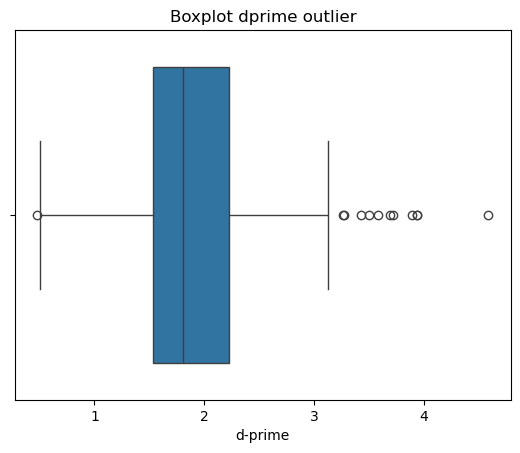

In [12]:
sns.boxplot(x=d_prime_values)
plt.title('Boxplot dprime outlier')
plt.xlabel('d-prime')
plt.show()

In [13]:
results_df_cleaned = results_df_cleaned[(results_df_cleaned['d_prime'] != 0) & (~results_df_cleaned['d_prime'].isna())]

In [14]:
print(results_df_cleaned)

     participant  session   stim  age  d_prime  median_rt
0              1        1  theta   28   2.1196     1.0917
4              1        2  gamma   28   2.0844     0.9730
8              1        3   sham   28   2.2215     0.9115
9              2        1  theta   25   2.2215     0.8953
13             2        2  gamma   25   3.1247     0.7077
..           ...      ...    ...  ...      ...        ...
309           35        2  theta   31   1.8102     1.2610
314           35        3   sham   31   2.2215     1.2255
316           36        1  gamma   20   1.6334     0.9368
320           36        2   sham   20   1.6241     0.7013
321           36        3  theta   20   1.5587     0.6554

[108 rows x 6 columns]


## Exclude dprime Outlier

In [15]:
exclusion_combinations = [
    (participant, session) 
    for participant, session in outliers_df[['participant', 'session']].itertuples(index=False, name=None)
]

# Loop over the exclusion combinations and set only the d_prime for those combinations to NaN
for participant, session in exclusion_combinations:
    results_df_cleaned.loc[
        (results_df_cleaned['participant'] == participant) & 
        (results_df_cleaned['session'] == session),
        'd_prime'
    ] = np.nan

print(results_df_cleaned)

     participant  session   stim  age  d_prime  median_rt
0              1        1  theta   28   2.1196     1.0917
4              1        2  gamma   28   2.0844     0.9730
8              1        3   sham   28   2.2215     0.9115
9              2        1  theta   25   2.2215     0.8953
13             2        2  gamma   25   3.1247     0.7077
..           ...      ...    ...  ...      ...        ...
309           35        2  theta   31   1.8102     1.2610
314           35        3   sham   31   2.2215     1.2255
316           36        1  gamma   20   1.6334     0.9368
320           36        2   sham   20   1.6241     0.7013
321           36        3  theta   20   1.5587     0.6554

[108 rows x 6 columns]


In [16]:
# Save DataFrame in CSV-File for further analysis in R
results_df_cleaned.to_csv('Final_DataSet.csv', index=False)

In [17]:
results_df_cleaned.to_csv(r"C:\Users\britt\Desktop\Final_DataSet.csv") 